# 2.a Document Parsing

In this notebook you will see:
- How to extract the text
- How to extract tables
- How to extract images

Here, only focusing on PDFs, more OCR solutions are not presented. All this is relevant but out of our scope.

# Setup

In [6]:
import os
import io
from time import time

from PIL import Image
import matplotlib.pyplot as plt

import pymupdf
import pymupdf4llm
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from unstructured.partition.pdf import partition_pdf
from pypdf import PdfReader

from utils.image_extraction import pdf_xobj_to_pil_image

In [7]:
path_to_docs = "data/docs"
path_to_document = os.path.join(path_to_docs, "alexnet_paper.pdf")

# Parse text

Depending on the document, different tools will be more appropriated (importance of tables, images, document format, ...). Below we present some of the main ones.

*Simple Comparison:*
| Tool         | What it is                      | Strength              | Weakness                   | Tables (as)                    | Images (extraction)                 | Positions (bbox/coords) |
| ------------ | ------------------------------- | --------------------- | -------------------------- | ------------------------------ | ----------------------------------- | ----------------------- |
| PyMuPDF      | Fast low-level PDF parser       | Speed + layout coords | Raw output, DIY chunking   | Text (heuristics)  | Native raw extraction               | Yes (strong)                     |
| PyMuPDF4LLM  | PyMuPDF -> Markdown chunks       | LLM-ready, easy       | Less flexible | Markdown                       | Limited / mostly references         | Yes                     |
| Docling      | Structured document AI parser   | Best layout & tables  | Heavy, slower              | Structured -> Markdown/JSON     | Advanced extraction & understanding | Yes                     |
| Unstructured | Multi-format ingestion pipeline | Many file types       | Heavy deps, slower         | Element types (table-ish)       | Raw extraction via elements         | Parser-dependent        |
| PyPDF        | Lightweight pure-Python reader  | Simple & light        | Poor layout quality        | Text                           | Raw extraction only                 | Limited                 |


## PyMuPDF

In [8]:
start_time = time()

doc = pymupdf.open(path_to_document)
all_blocks = []

for page in doc:
    page_images = []

    # Plain text
    text = page.get_text("text")
    # Blocks with coordinates (x0, y0, x1, y1, "text", block_no, block_type)
    blocks = page.get_text("blocks")
    # Word-level coordinates
    words = page.get_text("words")
    # Layout as dictionary
    layout = page.get_text("dict")
    # Images
    image_list = page.get_images(full=True)

    all_blocks.append(
        {
            "page": page.number + 1,
            "blocks": blocks,
            "words": words,
            "layout": layout,
            "images": image_list,
        }
    )

doc.close()

print(f"Processed document in {time() - start_time:.2f} seconds")

Processed document in 0.17 seconds


### Text

In [9]:
block_page_7 = all_blocks[6]

# Block provides position and text
print(block_page_7["blocks"][2], "\n")
# Words provide position and text
print(all_blocks[6]["words"][40], "\n")
# Layout provides detailed structure of the page and of the text font
print(all_blocks[6]["layout"]["width"], all_blocks[6]["layout"]["height"], "\n")
print(all_blocks[6]["layout"]["blocks"][2]["lines"][0], "\n")

(107.99998474121094, 154.22833251953125, 504.0032958984375, 217.9288330078125, 'Our results on ILSVRC-2010 are summarized in Table 1. Our network achieves top-1 and top-5\ntest set error rates of 37.5% and 17.0%5. The best performance achieved during the ILSVRC-\n2010 competition was 47.1% and 28.2% with an approach that averages the predictions produced\nfrom six sparse-coding models trained on different features [2], and since then the best pub-\nlished results are 45.7% and 25.7% with an approach that averages the predictions of two classi-\nﬁers trained on Fisher Vectors (FVs) computed from two types of densely-sampled features [24].\n', 2, 0) 

(169.56886291503906, 154.22833251953125, 228.2385711669922, 163.1348876953125, 'ILSVRC-2010', 2, 0, 3) 

612.0 792.0 

{'spans': [{'size': 9.962599754333496, 'flags': 4, 'bidi': 0, 'char_flags': 16, 'font': 'NimbusRomNo9L-Regu', 'color': 0, 'alpha': 255, 'ascender': 0.800000011920929, 'descender': -0.20000000298023224, 'text': 'Our', 'origi

### Tables

In [10]:
block_page_7 = all_blocks[6]

print(block_page_7["blocks"][3][4], "\n")

Model
Top-1
Top-5
Sparse coding [2]
47.1%
28.2%
SIFT + FVs [24]
45.7%
25.7%
CNN
37.5%
17.0%
 



### Images

(102, 0, 484, 346, 8, 'DeviceRGB', '', 'Im5', 'FlateDecode', 0)


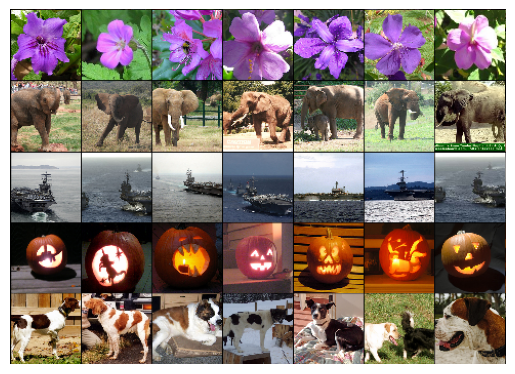

In [11]:
image_page_8 = all_blocks[7]["images"]

print(image_page_8[0])

doc = pymupdf.open(path_to_document)
xref = image_page_8[0][0]
base_image = doc.extract_image(xref)
image_bytes = base_image["image"]
image = Image.open(io.BytesIO(image_bytes))

plt.imshow(image)
plt.axis("off")
plt.show()

## PyMuPDF4LLM

In [12]:
start_time = time()

path_to_saved_images = "./images_pymupdf4llm"
md = pymupdf4llm.to_markdown(
    path_to_document,
    write_images=True,
    extract_tables=True,
    image_path=path_to_saved_images,
)

print(f"Processed document in {time() - start_time:.2f} seconds")

Warning - arguments ignored in legacy mode: {'extract_tables'}.
Processed document in 1.73 seconds


### Text

In [13]:
print(md[24365:24800])

 days on two NVIDIA GTX 580 3GB GPUs.


**6** **Results**


Our results on ILSVRC-2010 are summarized in Table 1. Our network achieves top-1 and top-5
test set error rates of **37.5%** and **17.0%** [5] . The best performance achieved during the ILSVRC2010 competition was 47.1% and 28.2% with an approach that averages the predictions produced
from six sparse-coding models trained on different features [2], and since then the best p


### Tables

In [14]:
print(md[25035:25200])

RC-2012 com
we tried. In the remainder of this paragraph, we use

|Model|Top-1|Top-5|
|---|---|---|
|_Sparse coding [2]_|_47.1%_|_28.2%_|
|_SIFT + FVs [24]_|_45.7%_|


### Images

Markdown snippet with image reference:
7


![](./images_pymupdf4llm/alexnet_paper.pdf-7-0.png)

![](./images_pymupdf4llm/alexnet_paper.pdf-7-1.png)

Figure 4: **(Left)** Eight ILSVRC-2010 test images and the f
------------------------------ 
 Displaying saved image:


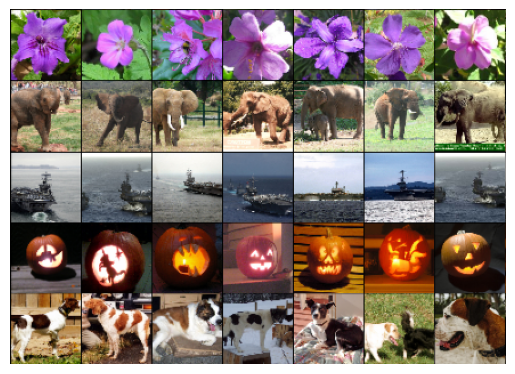

In [15]:
saved_images_name = "alexnet_paper.pdf-7-1.png"

print("Markdown snippet with image reference:")
print(md[28430:28600])

print("-" * 30, "\n", "Displaying saved image:")
plt.imshow(Image.open(os.path.join(path_to_saved_images, saved_images_name)))
plt.axis("off")
plt.show()

## Docling

In [16]:
start_time = time()

pipeline_options = PdfPipelineOptions()
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True

doc_converter = DocumentConverter(
    format_options={InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)}
)

conv_res = doc_converter.convert(path_to_document)

# Can export to Markdown as well
md = conv_res.document.export_to_markdown(image_mode=ImageRefMode.REFERENCED)
# Images can also be directly saved in the markdown
md_embedded = conv_res.document.export_to_markdown(image_mode=ImageRefMode.EMBEDDED)
# Or export to a dictionary, which provides more information (text location, etc.)
data = conv_res.document.export_to_dict()

print(f"Processed document in {time() - start_time:.2f} seconds")

[INFO] 2026-02-26 15:13:54,977 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-02-26 15:13:55,057 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\sieverin\SDSC\Code\sme-kt-zh-collaboration-rag\rag_venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-02-26 15:13:55,057 [RapidOCR] main.py:53: Using C:\Users\sieverin\SDSC\Code\sme-kt-zh-collaboration-rag\rag_venv\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-02-26 15:13:55,180 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-02-26 15:13:55,198 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\sieverin\SDSC\Code\sme-kt-zh-collaboration-rag\rag_venv\Lib\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-02-26 15:13:55,205 [RapidOCR] main.py:53: Using C:\Users\sieverin\SDSC\Code\sme-kt-zh-collaboration-rag\rag_venv\Lib\site-packages\rapidocr\models\ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 202

Processed document in 19.26 seconds


### Text

In [17]:
print(md[23618:24500])

Our results on ILSVRC-2010 are summarized in Table 1. Our network achieves top-1 and top-5 test set error rates of 37.5% and 17.0% 5 . The best performance achieved during the ILSVRC2010 competition was 47.1% and 28.2% with an approach that averages the predictions produced from six sparse-coding models trained on different features [2], and since then the best published results are 45.7% and 25.7% with an approach that averages the predictions of two classifiers trained on Fisher Vectors (FVs) computed from two types of densely-sampled features [24].

We also entered our model in the ILSVRC-2012 competition and report our results in Table 2. Since the ILSVRC-2012 test set labels are not publicly available, we cannot report test error rates for all the models that we tried. In the remainder of this paragraph, we use validation and test error rates interchangeably becaus


In [18]:
# The extracted data is rich, containing references to the layout, positions, etc.
print(data.keys())
print(data["body"].keys())
print(data["texts"][0].keys())

dict_keys(['schema_name', 'version', 'name', 'origin', 'furniture', 'body', 'groups', 'texts', 'pictures', 'tables', 'key_value_items', 'form_items', 'pages'])
dict_keys(['self_ref', 'children', 'content_layer', 'name', 'label'])
dict_keys(['self_ref', 'parent', 'children', 'content_layer', 'label', 'prov', 'orig', 'text', 'level'])


In [19]:
# We can find the shape and position of each text block
print(data["texts"][69]["prov"], "\n")
# And the content
print(data["texts"][69]["text"])

[{'page_no': 7, 'bbox': {'l': 108.0, 't': 637.5026526, 'r': 504.00338739999984, 'b': 574.1567743929206, 'coord_origin': 'BOTTOMLEFT'}, 'charspan': [0, 557]}] 

Our results on ILSVRC-2010 are summarized in Table 1. Our network achieves top-1 and top-5 test set error rates of 37.5% and 17.0% 5 . The best performance achieved during the ILSVRC2010 competition was 47.1% and 28.2% with an approach that averages the predictions produced from six sparse-coding models trained on different features [2], and since then the best published results are 45.7% and 25.7% with an approach that averages the predictions of two classifiers trained on Fisher Vectors (FVs) computed from two types of densely-sampled features [24].


### Tables

In [20]:
print(md[24773:25000])

| Model             | Top-1   | Top-5   |
|-------------------|---------|---------|
| Sparse coding [2] | 47.1%   | 28.2%   |
| SIFT + FVs [24]   | 45.7%   | 25.7%   |
| CNN               | 37.5%   | 17.0%   |

of five similar 


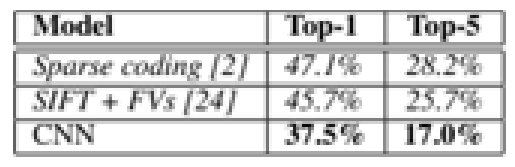

In [21]:
for i, (element, _level) in enumerate(conv_res.document.iterate_items()):
    if isinstance(element, TableItem) and i == 68:
        pil_image = element.get_image(doc=conv_res.document)
        plt.imshow(pil_image)
        plt.axis("off")
        plt.show()

### Images 

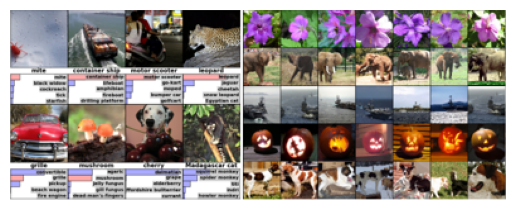

In [22]:
for i, (element, _level) in enumerate(conv_res.document.iterate_items()):
    if isinstance(element, PictureItem) and i == 78:
        pil_image = element.get_image(doc=conv_res.document)
        plt.imshow(pil_image)
        plt.axis("off")
        plt.show()

In [23]:
md[28280:28320]

'<!-- image -->\n\nIn the left panel of Fig'

In [24]:
print(md_embedded[11675:12000], "...")

![Image]( ...


## Unstructured

In [25]:
start_time = time()

images_output_dir = "./images_unstructured_pdf"
elements = partition_pdf(
    filename=path_to_document,
    infer_table_structure=True,
    extract_images_in_pdf=True,
    extract_image_block_types=["Image", "Table"],
    extract_image_block_output_dir=str(images_output_dir),
    chunking_strategy=None,
)

print(f"Processed document in {time() - start_time:.2f} seconds")

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Processed document in 57.23 seconds


In [26]:
element_types = set(type(el) for el in elements)
for t in element_types:
    print(t)

<class 'unstructured.documents.elements.Table'>
<class 'unstructured.documents.elements.Text'>
<class 'unstructured.documents.elements.Footer'>
<class 'unstructured.documents.elements.Formula'>
<class 'unstructured.documents.elements.ListItem'>
<class 'unstructured.documents.elements.NarrativeText'>
<class 'unstructured.documents.elements.FigureCaption'>
<class 'unstructured.documents.elements.Title'>
<class 'unstructured.documents.elements.Image'>


### Text

In [27]:
el = elements[82]

print("CATEGORY:", el.category, "\n")
print("TEXT:", el.text, "\n")
print("POSITION:", el.metadata.coordinates.points)

CATEGORY: Title 

TEXT: 6 Results 

POSITION: ((np.float64(519.5447998046875), np.float64(611.2722622222219)), (np.float64(519.5447998046875), np.float64(669.3878177777774)), (np.float64(795.522705078125), np.float64(669.3878177777774)), (np.float64(795.522705078125), np.float64(611.2722622222219)))


### Tables

In [28]:
print(elements[84])

We also entered our model in the ILSVRC-2012 com- petition and report our results in Table 2. Since the ILSVRC-2012 test set labels are not publicly available, we cannot report test error rates for all the models that we tried. In the remainder of this paragraph, we use validation and test error rates interchangeably because in our experience they do not differ by more than 0.1% (see Table 2). The CNN described in this paper achieves a top-5 error rate of 18.2%. Averaging the predictions


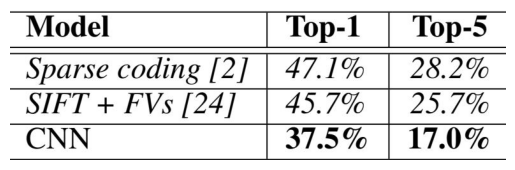

In [29]:
plt.imshow(Image.open(os.path.join(images_output_dir, "table-7-1.jpg")))
plt.axis("off")
plt.show()

### Images

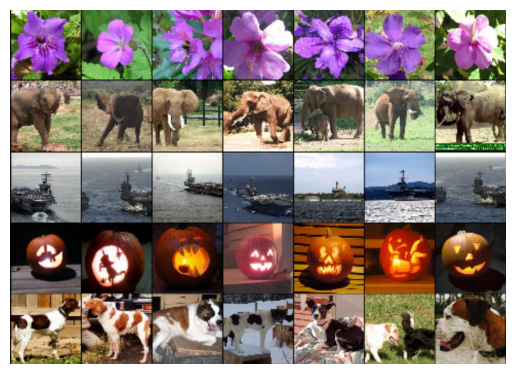

In [30]:
plt.imshow(Image.open(os.path.join(images_output_dir, "figure-8-5.jpg")))
plt.axis("off")
plt.show()

## PyPDF

In [31]:
reader = PdfReader(path_to_document, strict=False)

start_time = time()

texts = []
images = []
for i, page in enumerate(reader.pages):
    t = page.extract_text() or ""
    texts.append({"page": i + 1, "text": t})

    if "/Resources" in page and "/XObject" in page["/Resources"]:
        x_objects = page["/Resources"]["/XObject"].get_object()

        for obj_name in x_objects:
            xobj = x_objects[obj_name]
            images.append({"page": i + 1, "xobj": xobj})

print(f"Processed document in {time() - start_time:.2f} seconds")

Processed document in 0.27 seconds


### Text

In [32]:
# And text as wel, without layout information
print(texts[6]["text"][204:400])

Our results on ILSVRC-2010 are summarized in Table 1. Our network achieves top-1 and top-5
test set error rates of 37.5% and 17.0%5. The best performance achieved during the ILSVRC-
2010 competiti


### Tables

In [33]:
print(texts[6]["text"][764:961])


Model Top-1 Top-5
Sparse coding [2] 47.1% 28.2%
SIFT + FVs [24] 45.7% 25.7%
CNN 37.5% 17.0%
Table 1: Comparison of results on ILSVRC-
2010 test set. In italics are best results
achieved by others.


### Images

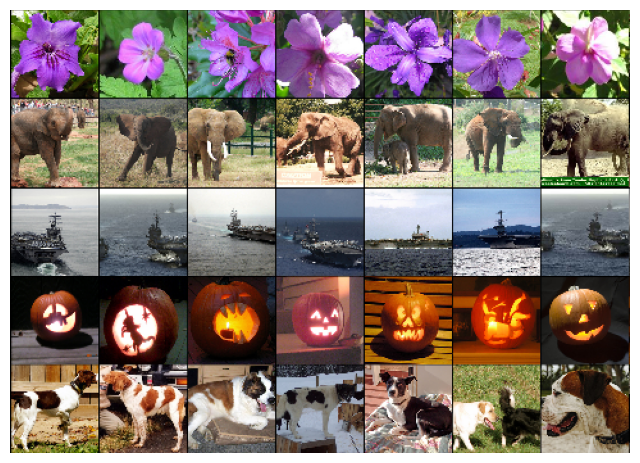

In [35]:
xobj = images[3]["xobj"]
img = pdf_xobj_to_pil_image(xobj, page_num=0, idx=0)

if img is not None:
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")

---------------